In [1]:
import glob

from torch.nn.functional import interpolate
from torch.utils.data import DataLoader

from inpainting import transforms
from inpainting.load import MergeDataset, SequenceDataset
from inpainting.utils import dilate, annotation_to_mask
from inpainting.visualize import tensor_to_pil_image


In [2]:
images_dataset = SequenceDataset(
    list(glob.glob(f'../data/interim/DAVIS/ResizedJPEGImages/tennis')),
    'image',
    sequence_length=1
)
masks_dataset = SequenceDataset(
    list(glob.glob(f'../data/interim/DAVIS/ResizedAnnotations/tennis')),
    'annotation',
    sequence_length=1,
    transform=transforms.Lambda(annotation_to_mask)
)
dataset = MergeDataset([images_dataset, masks_dataset], transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [3]:
images, masks = next(iter(data_loader))
image, mask = images[0], masks[0]

In [4]:
_, _, w, h = image.size()
image = interpolate(image, size=[w // 128 * 128, h // 128 * 128]).cuda()
mask = dilate(interpolate(mask, size=[w // 128 * 128, h // 128 * 128])).cuda()

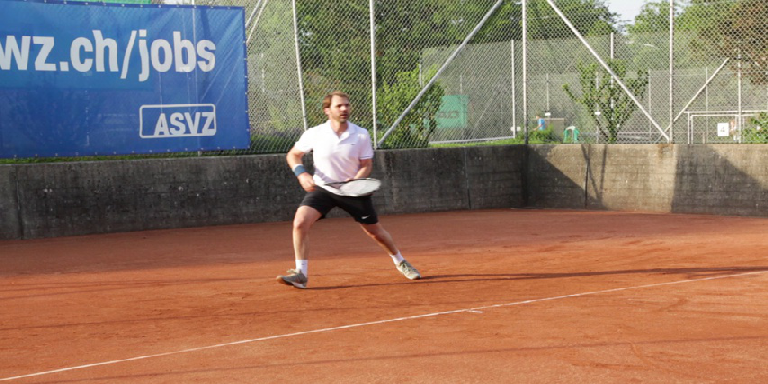

In [5]:
tensor_to_pil_image(image)

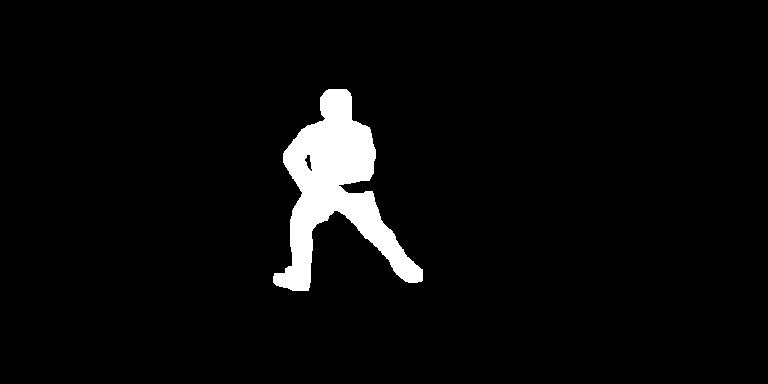

In [6]:
tensor_to_pil_image(mask)

C:\Users\jakub\anaconda3\envs\inpainting\lib\site-packages\torch\nn\functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


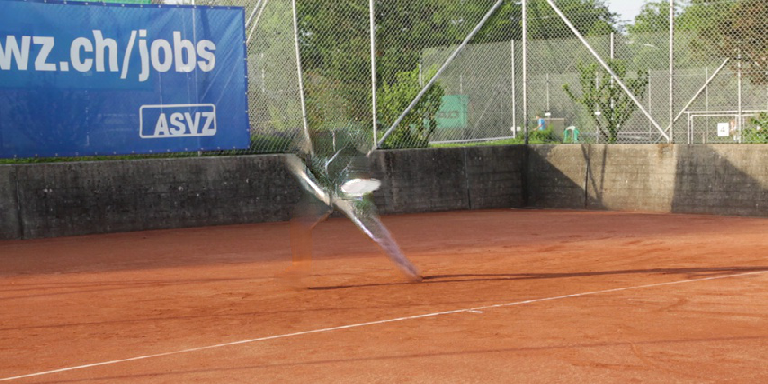

In [7]:
from inpainting.inpainting.deepfillv1.model import DeepFillV1Model

model = DeepFillV1Model('../models/inpainting/deepfillv1/imagenet_deepfill.pth').cuda()
result = model(image, mask)
tensor_to_pil_image(result)

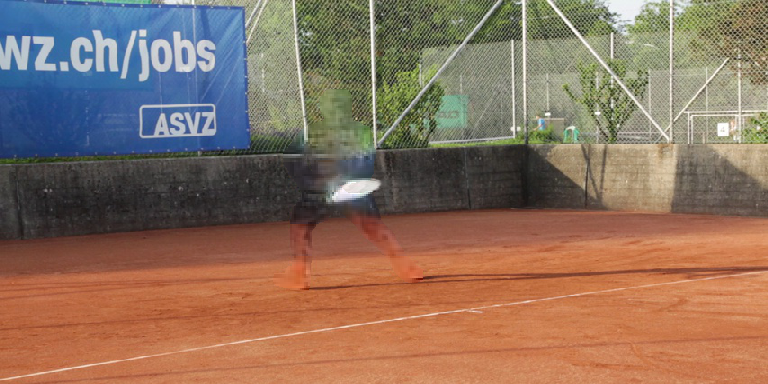

In [8]:
from inpainting.inpainting.deepfillv2.model import DeepFillV2Model

model = DeepFillV2Model('../models/inpainting/deepfillv2/latest_ckpt.pth.tar').cuda()
result = model(image, mask)
tensor_to_pil_image(result)

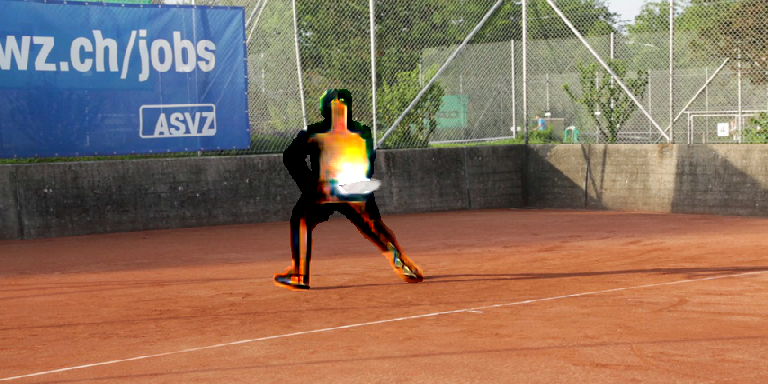

In [9]:
from inpainting.inpainting.pconvunet.model import PConvUNetModel

model = PConvUNetModel('../models/inpainting/pconvunet/1000000.pth').cuda()
result = model(image, mask)
tensor_to_pil_image(result)

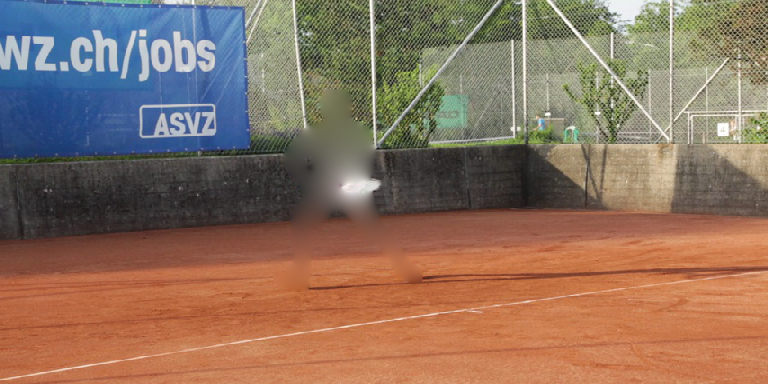

In [10]:
from inpainting.inpainting.kernel_inpainting import Inpainter

algorithm = Inpainter()
result = algorithm(image, mask)
tensor_to_pil_image(result)

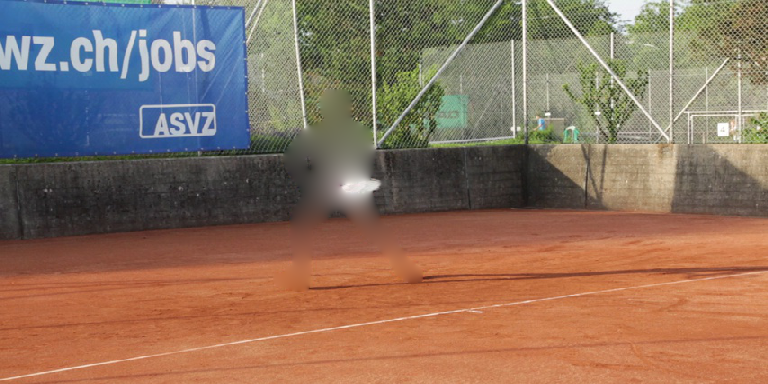

In [11]:
from inpainting.inpainting.region_fill import inpaint

result = inpaint(image, mask)
tensor_to_pil_image(result)